In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load Data

In [0]:
def LoadData(fname):
    """ Loads data """
    npzfile = np.load(fname)
    inputs_train = npzfile['inputs_train'].T / 255.0
    inputs_valid = npzfile['inputs_valid'].T / 255.0
    inputs_test = npzfile['inputs_test'].T / 255.0
    target_train = npzfile['target_train'].tolist()
    target_valid = npzfile['target_valid'].tolist()
    target_test = npzfile['target_test'].tolist()

    num_class = max(target_train + target_valid + target_test) + 1
    target_train_1hot = np.zeros([num_class, len(target_train)])
    target_valid_1hot = np.zeros([num_class, len(target_valid)])
    target_test_1hot = np.zeros([num_class, len(target_test)])

    for ii, xx in enumerate(target_train):
        target_train_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_valid):
        target_valid_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_test):
        target_test_1hot[xx, ii] = 1.0

    inputs_train = inputs_train.T
    inputs_valid = inputs_valid.T
    inputs_test = inputs_test.T
    target_train_1hot = target_train_1hot.T
    target_valid_1hot = target_valid_1hot.T
    target_test_1hot = target_test_1hot.T
    return inputs_train, inputs_valid, inputs_test, target_train_1hot, target_valid_1hot, target_test_1hot 

inputs_train, inputs_valid, inputs_test, target_train, target_valid, target_test = LoadData('/content/drive/My Drive/Colab Notebooks/toronto_face.npz')

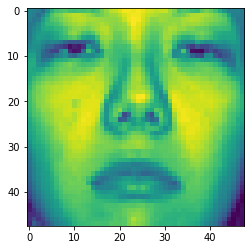

In [0]:
a = inputs_train[2].reshape(48,48)
plt.imshow(a)

In [0]:
class faceDataset(Dataset):
    def __init__(self, faceX, predictY):
        
        self.len = len(faceX)
        self.X = torch.empty((self.len, 1, 48, 48))
        self.Y = torch.empty((self.len, 7))
        #transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
        for i in range(self.len):
            self.X[i] = torch.from_numpy(faceX[i].reshape(48,48))
            self.Y[i] = torch.from_numpy(predictY[i])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

train = faceDataset(inputs_train,target_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=16, num_workers=0, shuffle=True)

In [0]:
totalimg = 7

def makeInput(num):
  result = []
  label = []
  for i in range(num):
    directory = '/content/drive/My Drive/Colab Notebooks/' + str(i) + '.png'
    img = cv2.imread(directory)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
    img = cv2.resize(img,(48,48))
    img_2304 = img.reshape(2304)
    result.append(img_2304)
    label.append([0, 0, 0, 0, 0, 0, 0])
  label = np.array(label)
  return result, label

# load own create data
own_test_input, own_test_label = makeInput(totalimg)
otest = faceDataset(own_test_input,own_test_label)
otest_loader = torch.utils.data.DataLoader(otest, batch_size=16, num_workers=0, shuffle=True)

# load test data
test = faceDataset(inputs_test,target_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=16, num_workers=0, shuffle=True)

# load valid data
valid = faceDataset(inputs_valid,target_valid)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=16, num_workers=0, shuffle=True)

# Convert image to canny


In [0]:
def covertCanny(inputs):
  new = []
  for i in range(len(inputs)):
    a = inputs[i].reshape(48,48)
    b = a *255
    b = b.astype(np.uint8)
    edges = cv2.Canny(b,30,150)
    edges = edges.reshape(2304)
    new.append(edges/255)
  return new

def merge(edge,origin):
  new = []
  for i in range(len(edge)):
    e = edge[i]
    o = edge[i]
    c = np.array(list(zip(e,o)))
    new.append(c)
  return np.array(new)

edge_train = covertCanny(inputs_train)
edge_valid = covertCanny(inputs_valid)
merge_train = merge(edge_train,inputs_train)
merge_valid = merge(edge_valid,inputs_valid)

# Network architecture

In [0]:
class CNN3max(nn.Module):
    def __init__(self):
        super(CNN3max, self).__init__()
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(18)

        self.conv2 = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(18)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.ff = Flatten()
        self.ln1 = nn.Linear(648,7)
    def forward(self, x):

        conv1 = self.conv1(x)
        x = self.bn1(conv1)
        x = self.pool1(x)  # size(18,24,24)

        conv2 = self.conv2(x)
        x = self.bn2(conv2)
        x = self.pool2(x) # size(18*18,12,12)

        conv3 = self.conv3(x)
        x = self.pool3(x)

        x = self.ff(x)

        x = F.dropout(x, p=0.3, training=self.training)
        x = self.ln1(x)
        return x

In [0]:
class CNN2max(nn.Module):
    def __init__(self):
        super(CNN2max, self).__init__()
        #here
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(18)

        
        self.conv2 = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(18)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.ff = Flatten()
        self.ln1 = nn.Linear(2592,100)
        self.ln2 = nn.Linear(100,7)
    def forward(self, x):

        conv1 = self.conv1(x)
        x = self.bn1(conv1)
        x = self.pool1(x)  # size(18,24,24)

        conv2 = self.conv2(x)
        x = self.bn2(conv2)
        x = self.pool2(x) # size(18*18,12,12)


        x = self.ff(x)


        x = self.ln1(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.ln2(x)
        return x
        # to visualize weight
        #return x, conv1, conv2

In [0]:
class CNN3maxRes(nn.Module):
    def __init__(self):
        super(CNN3maxRes, self).__init__()
        #here
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(18)

        self.convR = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.poolR = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(18)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.ff = Flatten()
        self.ln1 = nn.Linear(648,7)
    def forward(self, x):

        conv1 = self.conv1(x)
        j = self.bn1(conv1)
        j = self.pool1(j)  # size(18,24,24)
        
        r = self.convR(x)
        r = self.pool2(r)
        r = self.pool2(r)

        conv2 = self.conv2(j)
        x = self.bn2(conv2)
        x = self.pool2(x) + r# size(18*18,12,12)

        conv3 = self.conv3(x)
        x = self.pool3(x)

        x = self.ff(x)

        x = F.dropout(x, p=0.3, training=self.training)
        x = self.ln1(x)

        return x

In [0]:
class MyNet(nn.Module):
    def __init__(self,first,second):
        super(MyNet, self).__init__()
        self.ff = Flatten()
        self.ln1 = nn.Linear(2304,first)
        self.ln2 = nn.Linear(first,second)
        self.ln3 = nn.Linear(second,7)
        # self.end = nn.Softmax(dim=0)
    def forward(self, x):
        out = self.ff(x)
        out = self.ln1(out)
        out = self.ln2(out)
        out = F.relu(out)
        # out = F.dropout(out, p=0.2, training=self.training)
        out = self.ln3(out)
        # out = self.end(out)
        return out

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

# Train model

In [0]:
from tqdm import tqdm
isprint = False

def crossEL(output, labels):
  if isprint:
    print("-----------------------------")
    print("start",output)
    output = output
    m = nn.Softmax(dim=1)
    soft = m(output)
    print("soft", soft)
    logsoft = torch.log(soft)
    print("logsoft", logsoft)
    positive = -logsoft*labels
    print("time and postive", positive)
    total = positive.sum()
    print("total", total)
    print("-----------------------------")
  else:
    output = output
    m = nn.Softmax(dim=1)
    soft = m(output)
    logsoft = torch.log(soft)
    positive = -logsoft*labels
    total = positive.sum()
  return total


def buildNet(model, loss, epochs, lr, train_loader):
    iteration = []
    errorlst = []
    criterion = loss 
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.90, weight_decay=5e-4)
    optimizer = optim.Adam(model.parameters(), lr)
    model.train()
    model.cuda()
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
    for e in range(epochs):
        running_loss = 0
        for images, labels in tqdm(train_loader):
          images = images.cuda()
          labels = labels.cuda()
          #log_ps, conv1, conv2 = model(images)
          log_ps = model(images)
          loss = criterion(log_ps, labels)
          optimizer.zero_grad()
          loss.backward()          
          optimizer.step()
          running_loss += loss.item()
        else:
          iteration.append(e)
          errorlst.append(running_loss)
          print(e, f"training loss:{running_loss/len(train_loader)} ")
    print('finish training')
    return model, iteration, errorlst
    #return model, iteration, errorlst, conv1, conv2

#loss = nn.L1Loss()
#loss = nn.MSELoss()
loss = crossEL
lr = 0.001
epouch = 30
model = MyNet(64,128)
#model = CNN2max()
#model = CNN3max()
#model = CNN3maxRes()
# to visualize weight
#faceNet, iteration, trainLoss, conv1, conv2 = buildNet(model, loss, epouch, lr, train_loader)
faceNet, iteration, trainLoss = buildNet(model, loss, epouch, lr, train_loader)
#faceNet, iteration, validLoss = buildNet(model, loss, epouch, lr, valid_loader)

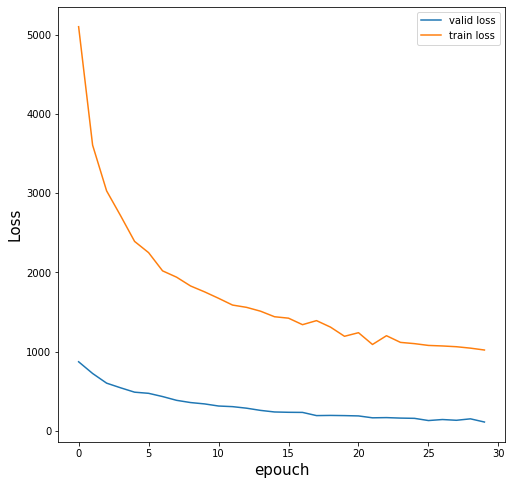

In [0]:
plt.figure(figsize=(8,8))
plt.xlabel('epouch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.plot(iteration, validLoss, label="valid loss")
plt.plot(iteration, trainLoss, label="train loss")
plt.legend()
plt.show()

# Test model

['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'neutral']

In [0]:
def testModel(model, loader):
    model.eval()
    results = []
    N = 0
    count = 0
    for images, labels in loader:
        images = images.cuda()
        labels = labels.cuda()
        log_ps = model(images)
        for i in range(len(images)):
          a = log_ps[i].cpu().detach() 
          y = labels[i].cpu().detach()
          results.append([a,images[i]])
          _,outputI = a.max(0)
          _,labelI = y.max(0)
          if outputI == labelI:
            count += 1
          N += 1
    return results, count/N
v_result,accuracy = testModel(faceNet, test_loader)
accuracy

0.7116883116883117

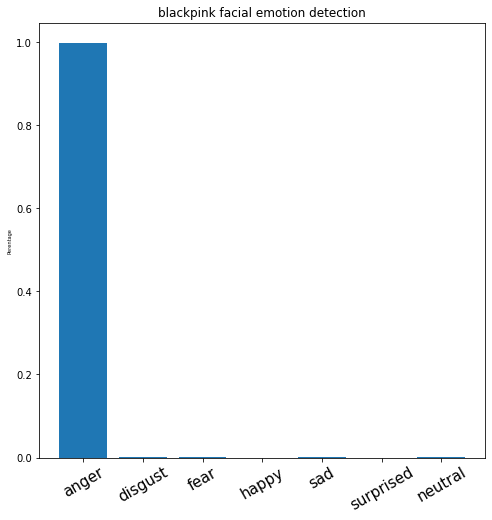

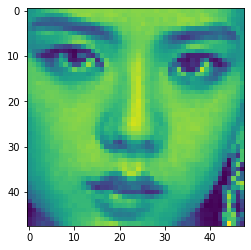

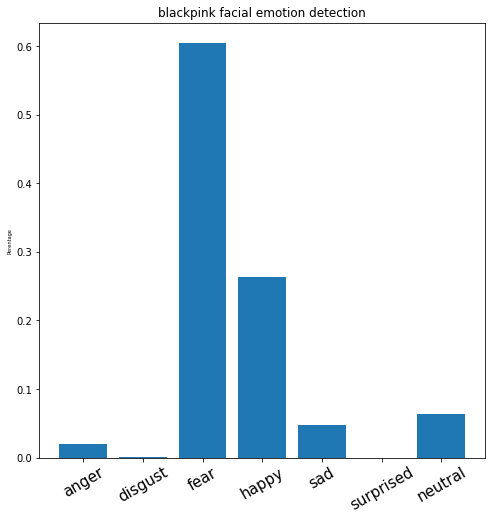

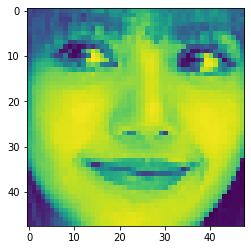

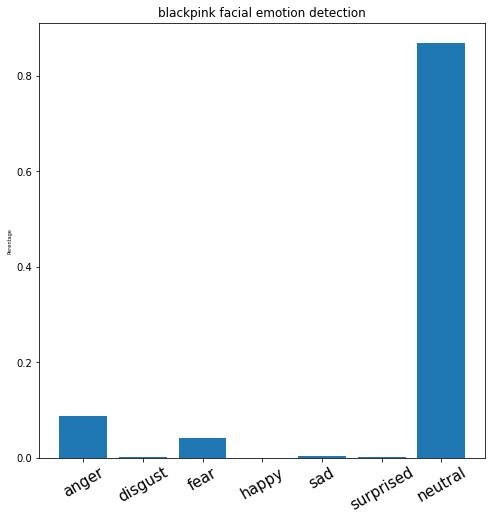

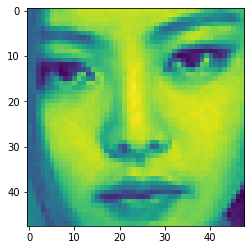

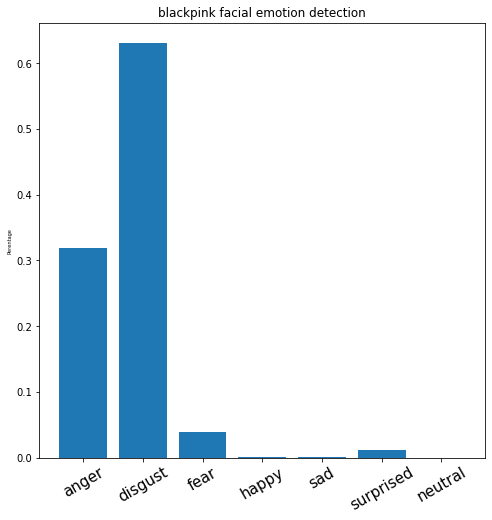

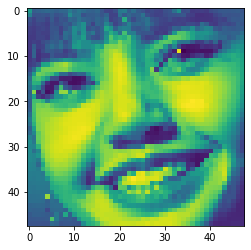

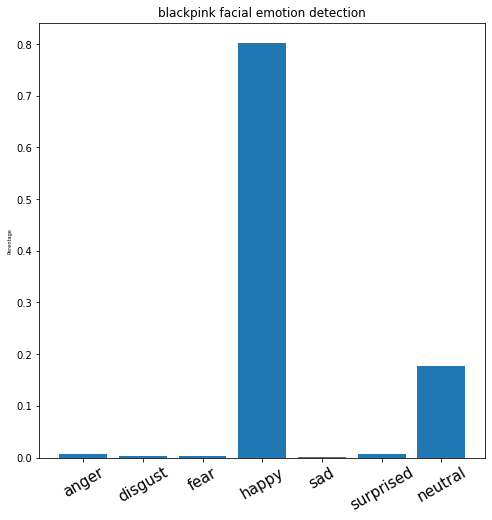

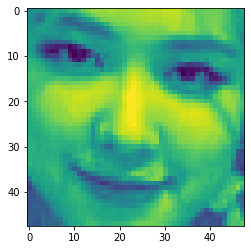

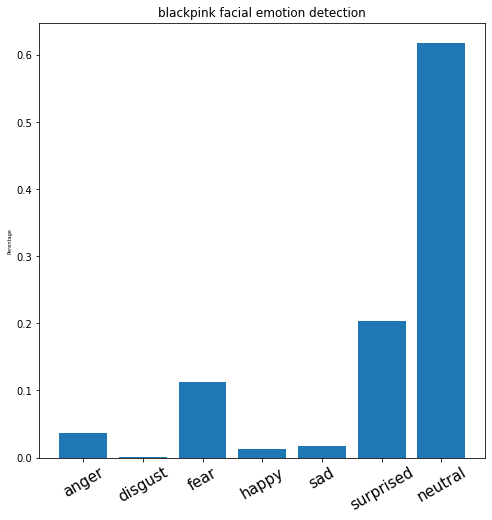

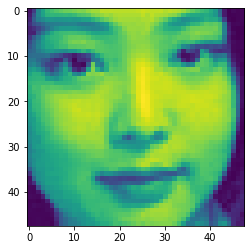

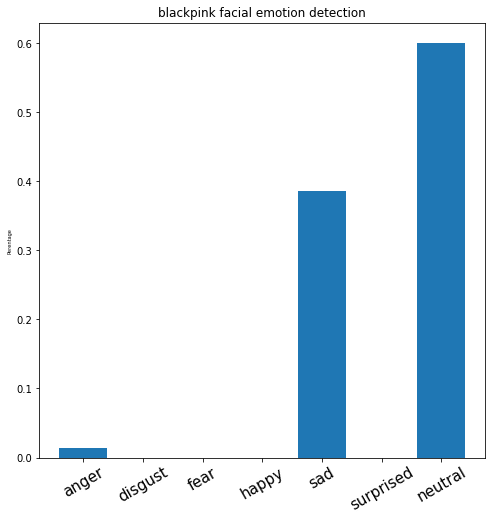

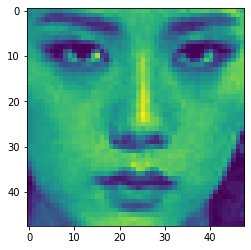

In [0]:
from google.colab import files
emotion = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'neutral']
save = False


def plot_bar_x(prediction,dir, save):
    # this is for plotting purpose
    index = np.arange(len(emotion))
    plt.bar(index, prediction)
    plt.ylabel('Perentage', fontsize=5)
    plt.xticks(index, emotion, fontsize=15, rotation=30)
    plt.title('blackpink facial emotion detection')
    if save:
      plt.savefig(dir)
      files.download(dir) 
    plt.show()
    

m = nn.Softmax(dim=0)
graphIndex = 0
for pair in v_result:
  plt.figure(figsize=(8,8))
  vector = pair[0]
  image = pair[1]
  softVector = m(vector)
  _,index = softVector.max(0)


  barname = "CNN00" + str(graphIndex) + ".png"
  plot_bar_x(softVector,barname,save)
  plt.imshow(image[0].cpu())
  plt.show()
  graphIndex += 1

# Visualize CNN filter wright

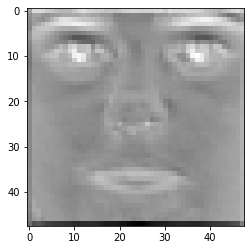

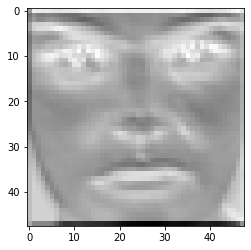

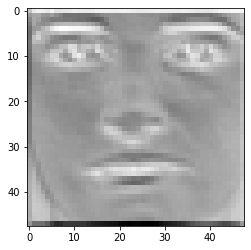

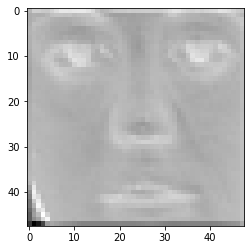

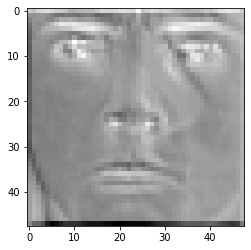

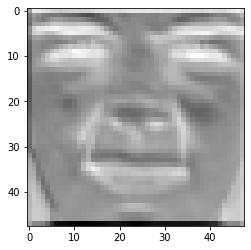

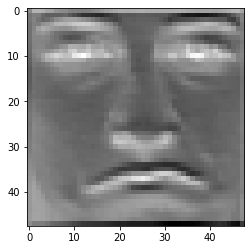

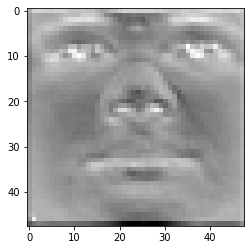

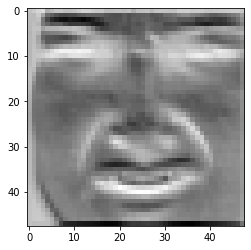

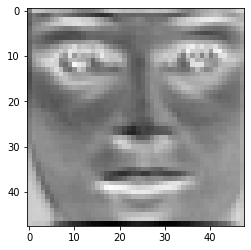

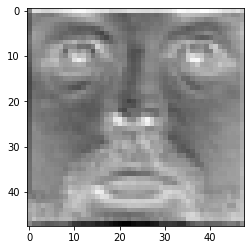

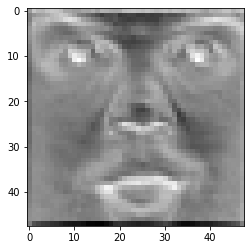

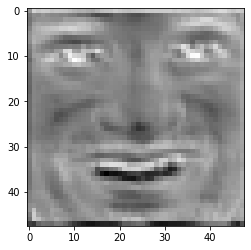

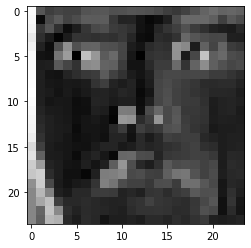

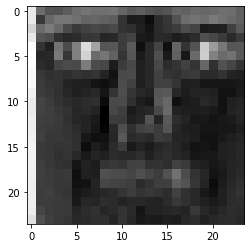

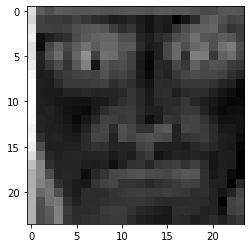

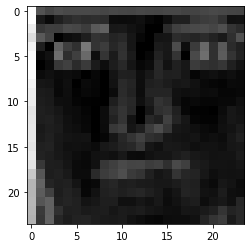

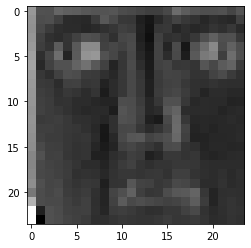

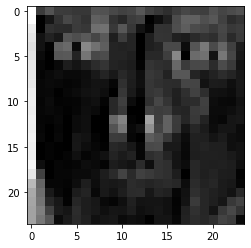

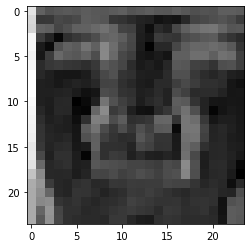

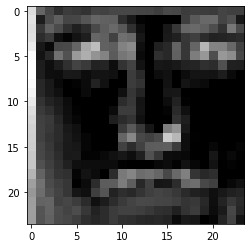

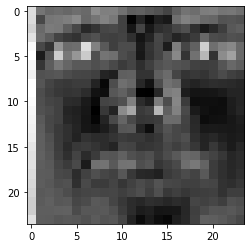

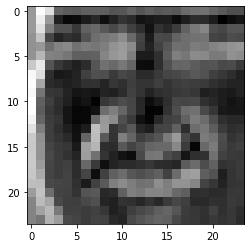

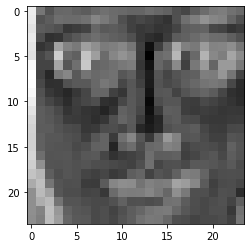

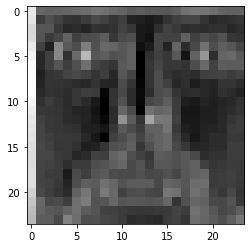

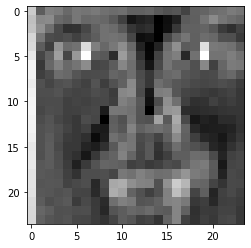

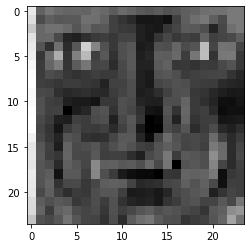

IndexError: ignored

In [0]:
total = conv1[0][0].cpu().data.numpy()
# first layer visualization
for i in range(1,14):
  a = conv1[i][17].cpu().data.numpy()
  plt.imshow(a, cmap="gray")
  plt.show()

# second layer visualization
for i in range(18):
  a = conv2[i][11].cpu().data.numpy()
  plt.imshow(a,cmap="gray")
  dir = "weight" + str(i)
  plt.show()